## Loading modules and data

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm
from utils import load_json_config

In [2]:
config = load_json_config("config.json")

In [3]:
!export CUDA_LAUNCH_BLOCKING=1

In [4]:
df = pd.read_csv(config["organized_dataset_name"])

In [5]:
!gdown {config["album_cover_imgs"]}

Downloading...
From (original): https://drive.google.com/uc?id=1LrygB3h79OvHPqOjkMHicoIthQ8DBfcy
From (redirected): https://drive.google.com/uc?id=1LrygB3h79OvHPqOjkMHicoIthQ8DBfcy&confirm=t&uuid=ab1dab14-67aa-48f2-9c59-214b2388e461
To: /home/yehor/Desktop/Genre_based_on_album_cover/album_covers.zip
100%|████████████████████████████████████████| 180M/180M [00:15<00:00, 11.7MB/s]


In [6]:
!unzip -o /home/yehor/Desktop/Genre_based_on_album_cover/album_covers.zip

Archive:  /home/yehor/Desktop/Genre_based_on_album_cover/album_covers.zip
  inflating: album_covers/63.jpg     
  inflating: album_covers/823.jpg    
  inflating: album_covers/2666.jpg   
  inflating: album_covers/2100.jpg   
  inflating: album_covers/1409.jpg   
  inflating: album_covers/189.jpg    
  inflating: album_covers/2114.jpg   
  inflating: album_covers/2672.jpg   
  inflating: album_covers/77.jpg     
  inflating: album_covers/837.jpg    
  inflating: album_covers/2882.jpg   
  inflating: album_covers/1353.jpg   
  inflating: album_covers/1435.jpg   
  inflating: album_covers/2128.jpg   
  inflating: album_covers/1421.jpg   
  inflating: album_covers/1347.jpg   
  inflating: album_covers/2896.jpg   
  inflating: album_covers/638.jpg    
  inflating: album_covers/2869.jpg   
  inflating: album_covers/1390.jpg   
  inflating: album_covers/604.jpg    
  inflating: album_covers/2699.jpg   
  inflating: album_covers/2841.jpg   
  inflating: album_covers/162.jpg    
  inflating: a

In [7]:
images_location = "/home/yehor/Desktop/Genre_based_on_album_cover/album_covers"

## Defining the dataset class

In [8]:
class AlbumDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image and label
        image_path = (f"{images_location}/{self.dataframe.iloc[idx]['album_id']}.jpg")
        label = self.dataframe.iloc[idx]['genre']
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Defining image transformations

In [9]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for pretrained CNNs
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                # Resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip
    transforms.RandomRotation(degrees=15),       # Random rotation
    transforms.ColorJitter(                      # Random color jitter
        brightness=0.3, contrast=0.3, saturation=0.3
    ),
    transforms.RandomAffine(                     # Random affine transformations
        degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)
    ),
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(                        # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    ),
])

## Splitting the data into 80% training, 10% validation and 10% testing

In [10]:
# split into 80% training and 20% temp (validation + testing)
train_data, temp_data = train_test_split(df, test_size=0.2, random_state=42)

# split temp data into 50% validation and 50% testing
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Training Set Size:", len(train_data))
print("Validation Set Size:", len(val_data))
print("Testing Set Size:", len(test_data))

Training Set Size: 1037
Validation Set Size: 130
Testing Set Size: 130


## Preprocessing and augmenting the data

In [11]:
# Training dataset with augmentation
train_dataset = AlbumDataset(train_data, transform=train_transforms)

# Validation and test datasets without augmentation
val_dataset = AlbumDataset(val_data, transform=val_test_transforms)
test_dataset = AlbumDataset(test_data, transform=val_test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Verifying data augmentation

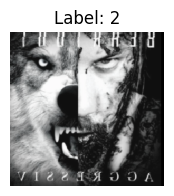

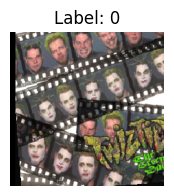

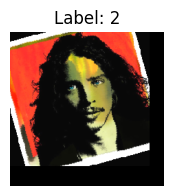

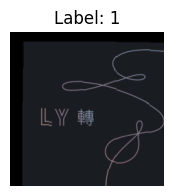

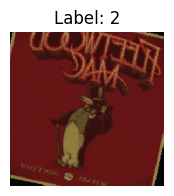

In [12]:
import matplotlib.pyplot as plt

# Get one batch of augmented training images
images, labels = next(iter(train_loader))

# Unnormalize and plot
def imshow(img):
    img = img.permute(1, 2, 0)  # Rearrange dimensions for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
    img = img.clip(0, 1)  # Clip values to valid range
    plt.imshow(img)
    plt.axis('off')

# Display the first 5 images in the batch
for i in range(5):
    plt.figure(figsize=(2, 2))
    imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

## Setting parameters

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 50
lr = 0.001
patience = 3
num_classes = len(df['genre'].unique())

best_model_name = "classifier_1.0"

## Initializing the model

In [22]:
# from sklearn, calculate weights inversely proportional to the class frequencies
class_weights = compute_class_weight('balanced', classes=np.unique(df['genre']), y=df['genre'])
# convert the computed weights into a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# load ResNet50
model = resnet50(weights=ResNet50_Weights.DEFAULT)
# iterate over model parameters with their names
for name, param in model.named_parameters():
    # "layer4" refers to the last convolutional block of ResNet50, which captures high-level features
    # "bn" refers to batch normalization layers, which help adapt to new data distribution
    if "layer4" in name or "bn" in name:
        param.requires_grad = True # unfreeze the mentioned layers
    else:
        param.requires_grad = False

# update FC layers
model.fc = nn.Sequential(
    # model.fc.in_features: Retrieves the number of input features to the original FC layer
    # nn.Linear is a fully connected layer
    # this first layer maps the input to 512 neurons
    nn.Linear(model.fc.in_features, 512),
    # setting ReLU as the activation function
    nn.ReLU(),
    # nn.Dropout randomly zeros out neurons (with 50% probability) to reduce overfitting
    nn.Dropout(0.5),
    # this second layer maps 512 neurons to num_classes (genres)
    nn.Linear(512, num_classes)
)
# move the model to the specified device (cpu or gpu)
model = model.to(device)

# loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
# filter(...) optimizes only unfrozen parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# StepLR reduces the learning rate by a factor of gamma every step_size epochs for better convergence
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

## Training

In [23]:
best_val_loss = float('inf')
patience_counter = 0
train_loss_history, val_loss_history = [], []

for epoch in range(epochs):
    # activate training mode, enabling dropout and batch normalization layers
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # reset gradients from the previous iteration
        optimizer.zero_grad()
        # forward feed
        outputs = model(images)
        # loss computation
        loss = criterion(outputs, labels)
        # backpropagation
        loss.backward()
        # weights update
        optimizer.step()

        # accumulate batch losses to compute average loss for the epoch
        running_loss += loss.item()
    train_loss_history.append(running_loss / len(train_loader))
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss_history[-1]:.4f}")

    ##############
    # VALIDATION #
    ##############

    # activates evaluation mode, disabling dropout and batch normalization updates
    model.eval()
    val_loss = 0.0
    all_labels, all_preds = [], []

    # disables gradient computation for efficiency and memory savings
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # retrieve the class with the highest probability for each sample (predicted class)
            _, preds = torch.max(outputs, 1)
            
            # collect ground truth and predicted labels for evaluation metrics
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss_history.append(val_loss / len(val_loader))
    print(f"Validation Loss: {val_loss_history[-1]:.4f}")

    # Classification report
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # reset patience_counter if val_loss improves; otherwise, increment it
        patience_counter = 0
        torch.save(model.state_dict(), best_model_name)
    else: #  stop training if validation loss stops improving for a defined number of epochs
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)]))

    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.04it/s]


Epoch 1/50, Training Loss: 1.0130
Validation Loss: 0.9737
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        39
           1       0.34      0.56      0.42        25
           2       0.76      0.58      0.66        66

    accuracy                           0.61       130
   macro avg       0.60      0.61      0.59       130
weighted avg       0.66      0.61      0.62       130



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.02it/s]


Epoch 2/50, Training Loss: 0.7622
Validation Loss: 1.3212
              precision    recall  f1-score   support

           0       0.69      0.74      0.72        39
           1       0.32      0.56      0.41        25
           2       0.66      0.44      0.53        66

    accuracy                           0.55       130
   macro avg       0.56      0.58      0.55       130
weighted avg       0.60      0.55      0.56       130



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.03it/s]


Epoch 3/50, Training Loss: 0.5817
Validation Loss: 1.0613
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        39
           1       0.50      0.24      0.32        25
           2       0.69      0.83      0.75        66

    accuracy                           0.68       130
   macro avg       0.64      0.60      0.60       130
weighted avg       0.67      0.68      0.66       130



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.02it/s]


Epoch 4/50, Training Loss: 0.4548
Validation Loss: 1.7558
Early stopping triggered.
